# VaR of returns series and backtesting (univariate) 
I use a **GJR-GARCH** model with **skewed-t** errors to estimate one-day ahead VaR of univariate return series. Then, I evaluate this risk measure according to backtesting techniques.

## 1. Load and prepare the data

In [8]:
# libraires
library(pracma)
library(ggplot2)

In [2]:
stock <- "AAPL"

t1 <- as.integer(ISOdate(2016,1,17,hour=0))
t2 <- as.integer(ISOdate(2022,6,9,hour=0))

url <- paste("https://query1.finance.yahoo.com/v7/finance/download/",
             stock,
             "?period1=", 
             as.integer(t1),
             "&period2=",
             as.integer(t2),
             "&interval=1d&events=history&includeAdjustedClose=true",
             sep="")

# Downloading the .csv file:
data <- read.csv(url)
data['Date'] <- as.Date(data$Date)
pricesdf <- data.frame(date=data$Date, price=data$Adj.Close)

# Compute log-returns:
genretdf <- function(pricesdf) {
  prices <- data.matrix(pricesdf)
  ret <- 100*(diff(log(prices[,2:ncol(prices)])))  
  date <- as.Date(pricesdf$date[-1]) 
  retdf <- data.frame(date,ret)
  return(retdf)
  }

retdf <- genretdf(pricesdf)
tail(retdf)

,date,ret
,<date>,<dbl>
1604,2022-06-01,-0.08738184
1605,2022-06-02,1.66715234
1606,2022-06-03,-3.93185999
1607,2022-06-06,0.52140293
1608,2022-06-07,1.74330472
1609,2022-06-08,-0.50560480


## 2. VaR (rolling window estimation)
### 2.1. GJR-GARCH
The most frequent procedure to estimate VaR (and ES) is to propose a parametric model, derive the VaR (or ES) implied by the parametric model, and then estimate the model parameters. In this exercise, I assume that returns $r_t$ follow a GJR-GARCH model with skewed-t errors, i.e., 
\begin{eqnarray} 
r_{t} &=& \mu + \sigma_{t} z_{t}\\ 
\sigma_{t}^2 &=&  \omega + \beta  \sigma_{t-1}^2 + \alpha (\sigma_{t-1} z_{t-1})^2 + \gamma (\sigma_{t-1} z_{t-1})^2 I_{\{z_{t-1}<0\}}
\end{eqnarray} where  
- $z_{t}$ is an i.i.d. random variable that follows a skewed-t of Hansen (1994) distribution, with degrees of freedom and asymmetry parameters  denoted by $2<\nu<\infty$ and $-1<\lambda<1$, respectively.
- $\mu$ denotes de unconditional mean.
- $\sigma_{t}^2$ corresponds to the conditional variance which describes a GJR-GARCH model.
- $I$ is an indicator function that takes the value of 1 if the inequality is satisfied and 0 otherwise.
- Positiveness restrictions: $\omega>0$, $\alpha\geq 0$, $\alpha+\gamma>0$ and $\beta\geq 0$. 
- Stationarity restriction:  $\alpha+\frac{1}{2}\gamma+\beta<1$.

There are 7 parameters to be estimated, e.g., $\theta:=(\mu, \omega, \beta, \alpha, \gamma,\nu,\lambda)$.

### 2.2. VaR
For a given $\alpha\in(0,1)$, the $\alpha$-level VaR at time $t$ is corresponds to the value that satisfies the following:
\begin{equation} 
\mathbf{P}\left(r_t\leq\text{VaR}_{t}(\alpha)\right)=\alpha \\
\end{equation}

In this particular case, given that returns are defined as above, the analytical expression to obtain $\text{VaR}_{t}(\alpha)$ is given by: 
\begin{equation} 
\text{VaR}_t(\alpha)=\mu + \sigma_t F^{-1}(\alpha|\nu,\lambda),
\end{equation} 
where $F^{-1}$ corresponds to the inverse of the skewed-t *cdf*.

Some required helper functions:

* `skewtinv(p,nu,lambda)` computes $z=F^{-1}(p|\nu,\lambda)$, given $p,\nu,\lambda$.
* `GJRloglik(par, ret)` computes $-L_{z}(\theta)= -\sum_{t=1}^{T}\log(f(z_{t}))$, given par$:=\theta$ and ret$:=\{r_{t}\}_{t=1}^T$. The minus symbol is because we estimate parameters, $\theta$, by maximizing this likelihood, however, the optimizer that we use here, `fmincon`, is able to minimize functions only. So that, that minus symbol transform our maximization problem into a minimization one.
* `GJRout(par, ret)` computes $-L_{z}(\theta)$, $\{\log(f(z_{t})\}_{t=1}^T$, $\{z_{t}\}_{t=1}^T$, $\{\sigma^2_t\}_{t=1}^T$ and $\sigma_{t+1}$, given par$:=\theta$ and ret$:=\{r_{t}\}_{t=1}^T$.
* `skewtpdf(x, nu, lambda)` computes the skewed-t *pdf*, e.g., $f(x|\nu,\lambda)$, given $x,\nu,\lambda$.

In [3]:
skewtinv <- function(p, nu, lambda) {
# USAGE:
#   X=skewtinv(P,V,LAMBDA)
 
# INPUTS:
#   P      - Values to be inverted, P in [0,1]
#   nu     - kurtosis parameter
#   lambda - skewness parameter 
     
# OUTPUTS:
#   X      - Skewed T distributed random variables corresponding to P

# COMMENTS:
#   nu > 2
#   -.99 < lambda < .99  
    
# REFERENCE:
#   [1] Hansen (1994), Intl.Econ.Rev. (35)

c <- gamma((nu+1)/2)/(sqrt(pi*(nu-2))*gamma(nu/2))
a <- 4*lambda*c*((nu-2)/(nu-1))
b <- sqrt(1 + 3*lambda^2 - a^2)
  
f1 <- which(p <  (1-lambda)/2)
f2 <- which(p >= (1-lambda)/2)

inv1 <- ((1-lambda)/b)*sqrt((nu-2)/nu)*qt(p[f1]/(1-lambda),nu) - a/b
inv2 <- ((1+lambda)/b)*sqrt((nu-2)/nu)*qt(0.5+1/(1+lambda)*(p[f2]-(1-lambda)/2),nu) - a/b

x <- rep(NaN,length(p))
x[f1] <- inv1
x[f2] <- inv2
return(x) 
}


GJRloglik <- function(par, ret) {
    # Mean: unconditional mean 
    # Errors distribution: skewed-t (Hansen, 1994)  
    TT <- length(ret)
    
    # Starting values:
    rbar <- mean(ret)
    condVar <- matrix(rep(0,TT),TT)
    epsi <- matrix(rep(0,TT),TT)
    z <- matrix(rep(0,TT),TT)
    condVar[1] <- mean((ret-rbar)^2)
    epsi[1] <- sqrt(condVar[1])
    z[1] <- 0
  
    # Unconditional mean:
    mu <- par[1]
  
    # Conditional variance:
    # sigma_{t}^2 = omega + beta*sigma_{t-1}^2 + alpha*epsilon_{t-1}^2 + gamma*epsilon{t-1}^2*ind{z_{t-1}<0}
    b0 <- par[2] # omega
    b1 <- par[3] # beta
    b2 <- par[4] # alpha
    b3 <- par[5] # gamma
    
    # GJR-GARCH(1,1) :
    for (t in 2 : TT)  {
      condVar[t] <-  b0 + b1*condVar[t-1] + b2*epsi[t-1]^2 + b3*min(epsi[t-1],0)^2 # GJR-GARCH(1,1) 
      z[t] <- (ret[t]-mu)/sqrt(condVar[t])   
      epsi[t] <- z[t]*sqrt(condVar[t]) 
    }
    sigmaPrime <- sqrt( b0 + b1*tail(condVar,1) + b2*tail(epsi,1)^2 + b3*min(tail(epsi,1),0)^2 )
    
    # Distribution parameters:
    a <- tail(par,2) 
    nu <- a[1] # degrees of freedom
    lambda <- a[2] # skewnes parameter
   
  
    # Log-likelihood
    logc <- lgamma((nu+1)/2) - lgamma(nu/2) - log(sqrt(pi*(nu-2))) 
    c = exp(logc) 
    a <- 4*lambda*c*((nu-2)/(nu-1))
    logb <- 0.5*log(1 + 3*lambda^2 - a^2)
    b <- exp(logb)
    f1 <- which(z <  (-a/b))
    f2 <- which(z >= (-a/b))
    ll <- rep(NaN,length(z))
    ll1 <- logb + logc - ((nu+1)/2)*log(1 + (1/(nu-2))*((b*z[f1]+a)/(1-lambda))^2 ) - 0.5*log(condVar[f1])
    ll2 <- logb + logc - ((nu+1)/2)*log(1 + (1/(nu-2))*((b*z[f2]+a)/(1+lambda))^2 ) - 0.5*log(condVar[f2])
    ll[f1] <- ll1
    ll[f2] <- ll2 
    LL <- -(sum(ll[2:length(ll)]))
    
  return(LL)
}


GJRout <- function(par, ret) {
    # Mean: unconditional mean 
    TT <- length(ret)

    # Starting values:
    rbar <- mean(ret)
    condVar <- matrix(rep(0,TT),TT)
    epsi <- matrix(rep(0,TT),TT)
    z <- matrix(rep(0,TT),TT)
    condVar[1] <- mean((ret-rbar)^2)
    epsi[1] <- sqrt(condVar[1])
    z[1] <- 1

    # Unconditional mean:
    mu <- par[1]

    # sigma_{t}^2 = omega + beta*sigma_{t-1}^2 + alpha*epsilon_{t-1}^2 + gamma*epsilon{t-1}^2*ind{z_{t-1}<0}
    b0 <- par[2] # omega
    b1 <- par[3] # beta
    b2 <- par[4] # alpha
    b3 <- par[5] # gamma
  
    # GJR-GARCH(1,1) :
    for (t in 2 : TT)  {
      condVar[t] <-  b0 + b1*condVar[t-1] + b2*epsi[t-1]^2 + b3*min(epsi[t-1],0)^2 # GJR-GARCH(1,1) 
      z[t] <- (ret[t]-mu)/sqrt(condVar[t])   
      epsi[t] <- z[t]*sqrt(condVar[t]) 
    }
    sigmaPrime <- sqrt( b0 + b1*tail(condVar,1) + b2*tail(epsi,1)^2 + b3*min(tail(epsi,1),0)^2 )
  

    # shape parameters:
    a <- tail(par,2) 
    nu <- a[1] # degrees of freedom
    lambda <- a[2] # skewnes parameter
  

    # Log-likelihood
    logc <- lgamma((nu+1)/2) - lgamma(nu/2) - log(sqrt(pi*(nu-2))) 
    c = exp(logc) 
    a <- 4*lambda*c*((nu-2)/(nu-1))
    logb <- 0.5*log(1 + 3*lambda^2 - a^2)
    b <- exp(logb)
    f1 <- which(z <  (-a/b))
    f2 <- which(z >= (-a/b))
    ll <- rep(NaN,length(z))
    ll1 <- logb + logc - ((nu+1)/2)*log(1 + (1/(nu-2))*((b*z[f1]+a)/(1-lambda))^2 ) - 0.5*log(condVar[f1])
    ll2 <- logb + logc - ((nu+1)/2)*log(1 + (1/(nu-2))*((b*z[f2]+a)/(1+lambda))^2 ) - 0.5*log(condVar[f2])
    ll[f1] <- ll1
    ll[f2] <- ll2 
    LL <- -(sum(ll[2:length(ll)]))
 
    result <- list(LL=LL,ll=ll,z=z,condVar=condVar, sigmaPrime=sigmaPrime)
    return(result)
}


skewtpdf <- function(x, nu, lambda) {
  # Compute the Hansen's skewed-t PDF (equation 10 in the paper). 
  
  # COMMENTS:
  #   nu > 2
  #   -.99 < lambda < .99  
  
  # REFERENCE:
  #   [1] Hansen (1994), Intl.Econ.Rev. (35)
  
  c <- gamma((nu+1)/2)/(sqrt(pi*(nu-2))*gamma(nu/2))
  a <- 4*lambda*c*((nu-2)/(nu-1))
  b <- sqrt(1 + 3*lambda^2 - a^2)
  
  f1 <- which(x <  -a/b)
  f2 <- which(x >= -a/b)
  
  y1 <- 1 + (1/(nu-2))*((b*x[f1]+a)/(1-lambda))^2
  y2 <- 1 + (1/(nu-2))*((b*x[f2]+a)/(1+lambda))^2
  
  density = rep(NaN,length(x))
  density[f1] <- b*c*y1^(-(nu+1)/2) 
  density[f2] <- b*c*y2^(-(nu+1)/2) 
 
  return(density) 
}

### Rolling window estimation:
* **In sample:** first $T_0$ observations.
* **Out-of-sample:** last $T-T_0$ observations.

In [4]:
# settings
T0 <- 500 # in-sample size (estimation window)
alpha <- 0.05 # coverage level for VaR and ES

In [5]:
# rolling window estimation
TT <- nrow(retdf)
OOS <- TT-T0 
par <- matrix(rep(NaN,7*OOS),OOS) # I will store here the estimated paremeters of each estimation window
sigmaprime <- NULL # I will store here one-day-ahead standard deviation of returns
VaR <- NULL
 

# Optimization restrictions:
lb <- c(-100, rep(0.001,3), -1 ,  2.01, -0.999)  
ub <- c(rep(100,6), 0.999)                    
A  <- matrix(rbind(c(0, 0, 1, 1, 0.5, 0, 0), c(0, 0, 0, -1, -1, 0, 0)), 2)  
b  <- matrix(c(0.999, -0.001),2)    
Aeq  <- NULL
beq  <- NULL
  
# Rolling  window loop:
t <- 1
while (t <= OOS) { 
    tt <- t+T0-1
    ret <- retdf[t:tt,"ret"]
    mu0 <- mean(ret)
    omega0 <- 0.01 ; beta0 <- 0.8 ; alpha0 <- 0.08 ; gamma0 <- 0.09
    nu0 <- 4 ; lambda0 <- - 0.2
    x0 <- c(mu0, omega0, beta0, alpha0, gamma0, nu0, lambda0) 
    x1 <- fmincon(x0 = x0, 
                  ret = ret, 
                  GJRloglik, # objective function
                  ub=ub, lb=lb, 
                  A=A, b=b, 
                  Aeq=Aeq, beq=beq, tol=1e-04)
    par0 <- x1$par  
    par[t,] <- par0  
    out <- GJRout(par=as.numeric(par0), ret=ret) 
    sigmaprime <- rbind(sigmaprime, out$sigmaPrime)
    VaR0 <- par0[1] + tail(sigmaprime,1)*skewtinv(alpha,par0[6],par0[7])
    VaR <- rbind(VaR, VaR0)
    t <- t + 1     
}

Date <- retdf$date
Date <- subset(retdf$date, (retdf$date >= as.Date(Date[T0+1])))
   
pardf <-  data.frame(Date,par)
colnames(pardf) <- c("date","mu","omega","beta","alpha","gamma","nu","lambda")

## 3. Visualization

In [18]:
OOSdf <- data.frame(Date,"ret"=subset(retdf$ret, (retdf$date >= as.Date(retdf$date[T0+1]))),VaR)
rownames(OOSdf) <- NULL
head(OOSdf)

,Date,ret,VaR
,<date>,<dbl>,<dbl>
1,2018-01-12,1.02732889,-1.320911
2,2018-01-16,-0.50950873,-1.306088
3,2018-01-17,1.63814645,-1.355038
4,2018-01-18,0.08928376,-1.347626
5,2018-01-19,-0.44726750,-1.303778
6,2018-01-22,-0.82150811,-1.321102


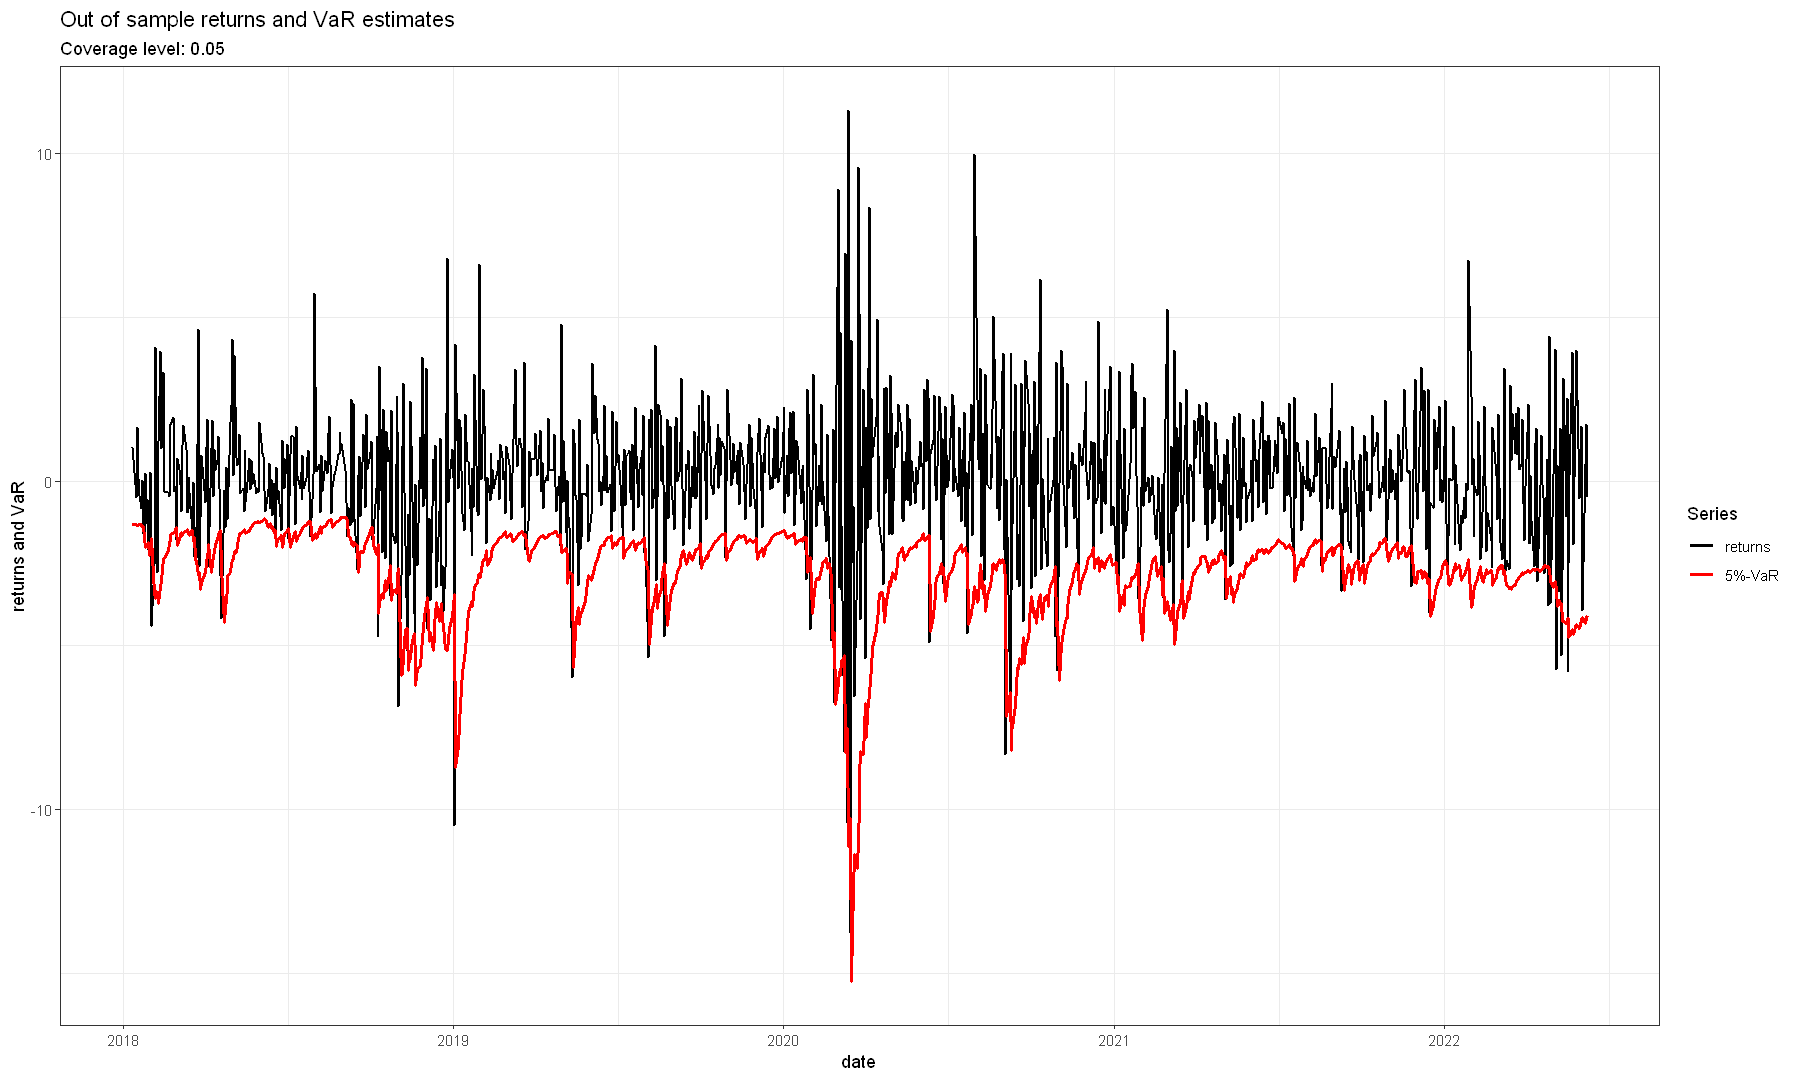

In [94]:
labels <- c("returns" = "black", "5%-VaR" = "red")
ffigure <- ggplot(OOSdf, aes(x = Date)) +
  geom_line(aes(y = ret, color="returns"), linetype = "solid", size = 0.8) +
  geom_line(aes(y = VaR, color="5%-VaR"), linetype = "solid", size = 1) +
  labs(title = "Out of sample returns and VaR estimates",
       subtitle = paste0("Coverage level: ", alpha),
       #caption = " ",
       color = "Series",
       x = "date",
       y = "returns and VaR") +
  scale_color_manual(values = labels)
options(repr.plot.width=15, repr.plot.height=9)
ffigure +  theme_bw(base_line_size = 0.1)

## 4. Backtesting
### 4.1. Unconditional coverage test of Kupiec (1995)

The unconditional coverage test is proposed by Kupiec (1995). This test is based on the fact that, if the
model is correctly specified, then the so-called hit variables $h_{t}\equiv 
\mathbb{I}(r_{t}<$VaR$_{t}(\alpha))$, where $\mathbb{I%
}(\cdot )$ is the indicator function, are independent Bernoulli random
variables, and hence $\sum_{t=T_{0}+1}^{T}h_{t}$ follows a Binomial
distribution Bi$(T-T_{0},\alpha )$. The test statistic is:
\begin{equation*}
LR_{\text{UC}}=-2\ln \left( \frac{\alpha ^{N}(1-\alpha )^{T-T_{0}-N}%
}{\widehat{\alpha }^{N}(1-\widehat{\alpha })^{T-T_{0}-N}}\right) ,
\end{equation*} 
where $N\equiv \sum_{t=T_{0}+1}^{T}\widehat{h}_{t},$ $\widehat{\alpha }%
\equiv N/(T-T_{0})$ and $\widehat{h}_{t}\equiv \mathbb{I}(r_{t}<\widehat{%
\text{VaR}}_{t}(\alpha))$. Under the null hypothesis
that the model is correctly specified, the asymptotic distribution of $LR_{%
\text{UC}}$ is $\chi _{1}^{2};$ thus, the null hypothesis of correct
specification is rejected at the $5\%$ significance level if the value of $%
LR_{\text{UC}}$ for the sample is above $\chi _{1,0.05}^{2}=3.8415.$

In [71]:
# Unconditional coverage test
# H0: P(hit=1) = alpha
hit = OOSdf$ret < OOSdf$VaR  
N = sum(hit)  
alphahat <- N/OOS
LRuc <- -2*log(((1-alpha)^(OOS-N)*alpha^N)/((1-alphahat)^(OOS-N)*alphahat^N))
pval <- 1-pchisq(LRuc,1)
print(data.frame("alpha_hat"=round(alphahat,4),"statistic"=round(LRuc,4),"p-value"=round(pval,4),"reject_H0"=LRuc>qchisq(0.95,1)))

  alpha_hat statistic p.value reject_H0
1    0.0631    3.7238  0.0536     FALSE


We do not reject the null hypothesis of unconditional coverage with a significance level of 5%.

### 4.2. Independence test of Christoffersen (1998)

This test is based on the fact that, if the model is correctly specified, then hits are
independent over time; hence, if we denote $\alpha _{ij}\equiv
P(h_{t+1}=j\mid h_{t}=i)$ for $i,j=0,1$, then $\alpha _{i1}$ must be equal
to $\alpha ,$ both when $i=0$ and $i=1$, and $\alpha _{i0}$ must be equal to 
$1-\alpha ,$ both when $i=0$ and $i=1$. The test stastistic is 
\begin{equation}
LR_{\text{IND}}=-2\ln \left( \frac{\hat{\alpha}^{N_{01}+N_{11}}(1-\hat{\alpha%
})^{N_{00}+N_{10}}}{\widehat{\alpha }_{01}^{N_{01}}(1-\widehat{\alpha }%
_{01})^{N_{00}}\widehat{\alpha }_{11}^{N_{11}}(1-\widehat{\alpha }%
_{11})^{N_{10}}}\right)
\end{equation}
where $N_{ij}\equiv \sum_{t=T_{0}+1}^{T-1}\mathbb{I}(\widehat{h}_{t+1}=j)%
\mathbb{I}(\widehat{h}_{t}=i),$ for $i,j=0,1,$ $\widehat{\alpha }_{01}\equiv
N_{01}/\left( N_{00}+N_{01}\right) $ and $\widehat{\alpha }_{11}\equiv
N_{11}/\left( N_{10}+N_{11}\right) $. Under the null hypothesis that the
model is correctly specified, the asymptotic distribution of $LR_{\text{IND}%
} $ is also $\chi _{1}^{2};$ thus, the null hypothesis of correct
specification is rejected at the $5\%$ significance level if the value of $%
LR_{\text{IND}}$ for the sample is above $\chi _{1,0.05}^{2}=3.8415.$

In [95]:
# Independence test
# H0: independence (no clusters of hits)
# H1: first-order Markov process

N01 = sum(OOSdf$ret[-1] < OOSdf$VaR[-1] & OOSdf$ret[1:(OOS-1)] > OOSdf$VaR[1:(OOS-1)]) # 1 if (h_{t+1}=1 and h_{t}=0)
N10 = sum(OOSdf$ret[-1] > OOSdf$VaR[-1] & OOSdf$ret[1:(OOS-1)] < OOSdf$VaR[1:(OOS-1)]) # 1 if (h_{t+1}=0 and h_{t}=1)
N11 = sum(OOSdf$ret[-1] < OOSdf$VaR[-1] & OOSdf$ret[1:(OOS-1)] < OOSdf$VaR[1:(OOS-1)]) # 1 if (h_{t+1}=1 and h_{t}=1)
N00 = sum(OOSdf$ret[-1] > OOSdf$VaR[-1] & OOSdf$ret[1:(OOS-1)] > OOSdf$VaR[1:(OOS-1)]) # 1 if (h_{t+1}=0 and h_{t}=0)

alphahat = (N01+N11)/(N00+N10+N01+N11)
alpha01 = N01/(N00+N01) 
alpha11 = N11/(N10+N11)

LRind <- -2*log((alphahat^(N01+N11)*(1-alphahat)^(N00+N10))/((alpha01^N01)*((1-alpha01)^N00)*(alpha11^N11)*((1-alpha11)^N10)))
pval <- 1-pchisq(LRind,1)

print(data.frame("statistic"=round(LRind,4),"p-value"=round(pval,4),"reject_H0"=LRind>qchisq(0.95,1)))

  statistic p.value reject_H0
1    1.8535  0.1734     FALSE


We do not reject the null hypothesis of independence with a significance level of 5%.  

**References:**
* Hansen, B. E. (1994). “Autoregressive conditional density estimation,” International Economic Review, 705–730.
* Kupiec, P. H. (1995). “Techniques for Verifying the Accuracy of Risk Measurement Models”, The Journal of Derivatives, 3, 73–84.
* Christoffersen, P.F. (1998). "Evaluating interval forecasts", International Economic Review, 39, 841–862.